import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

Set start and end time. It is one year by default

In [43]:
end = datetime.date.today()
start = end - datetime.timedelta(365)


function to calculate MA and EMA

In [44]:
def caculateEMA(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) +
                   ema[-1] * (1 - (smoothing / (1 + days))))
    return [None]*(days-1)+ema


def caculateMA(prices, days):
    return prices.rolling(days).mean()


Process the data frame

In [56]:
def addMAData(prices_df):
    prices_df['MA20'] = caculateMA(prices_df['Close'], 20)
    prices_df['MA60'] = caculateMA(prices_df['Close'], 60)
    prices_df['MA120'] = caculateMA(prices_df['Close'], 120)
    prices_df['EMA20'] = caculateEMA(prices_df['Close'], 20)
    prices_df['EMA60'] = caculateEMA(prices_df['Close'], 60)
    prices_df['EMA120'] = caculateEMA(prices_df['Close'], 120)


def plotMAData(prices_df):
    prices_df['Close'].plot(figsize=(15, 7), label='Close',c='black')
    prices_df['MA20'].plot(label='MA20', c='red',linestyle='dashed')
    prices_df['EMA20'].plot(label='EMA20', c='red')
    prices_df['MA60'].plot(label='MA60', c='orange',linestyle='dashed')
    prices_df['EMA60'].plot(label='EMA60', c='orange')
    prices_df['MA120'].plot(label='MA120', c='blue',linestyle='dashed')
    prices_df['EMA120'].plot(label='EMA120', c='blue')
    plt.legend()


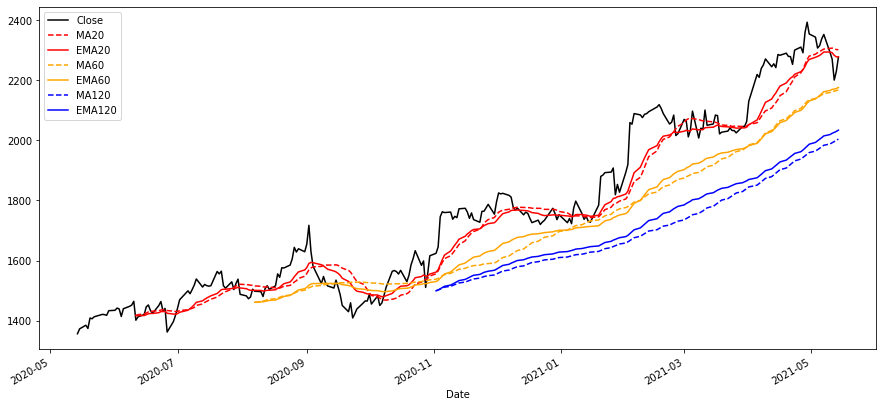

In [57]:
google = web.DataReader('GOOGL', 'yahoo', start, end)
addMAData(google)
plotMAData(google)